In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sympy import Symbol, diff, linsolve

# Data

In [2]:
data = pd.read_csv(".\\data\\google_stocks\\AABA_2006-01-01_to_2018-01-01.csv")
data.head()

,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,39.69,41.22,38.79,40.91,24232729,AABA
1,2006-01-04,41.22,41.90,40.77,40.97,20553479,AABA
2,2006-01-05,40.93,41.73,40.85,41.53,12829610,AABA
3,2006-01-06,42.88,43.57,42.80,43.21,29422828,AABA
4,2006-01-09,43.10,43.66,42.82,43.42,16268338,AABA


In [3]:
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data.head(2)

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,39.69,41.22,38.79,40.91,24232729,AABA
2006-01-04,41.22,41.90,40.77,40.97,20553479,AABA


Text(0.5, 1.0, 'Low')

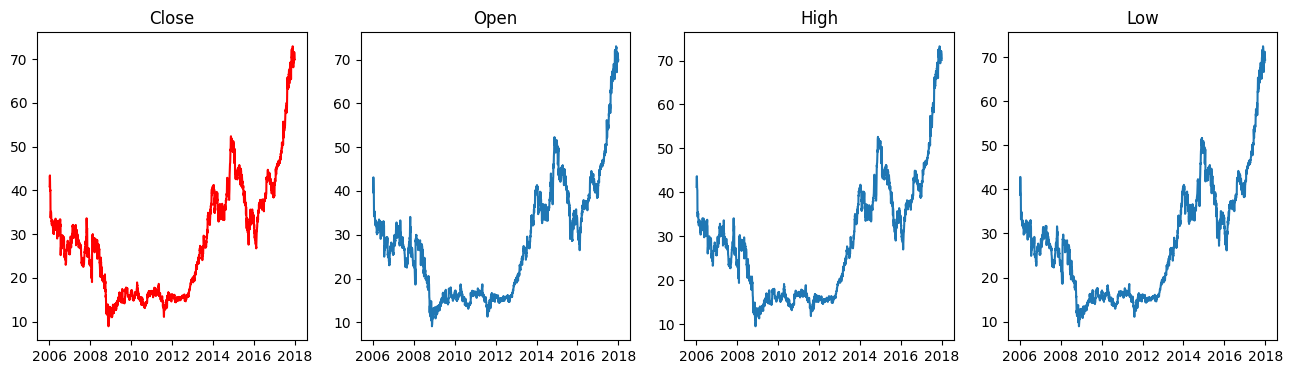

In [4]:
fig, ax = plt.subplots(1, 4, figsize=(16, 4))
ax[0].plot(data.index, data['Close'], color='r')
ax[1].plot(data.index, data['Open'])
ax[2].plot(data.index, data['High'])
ax[3].plot(data.index, data['Low'])

ax[0].set_title('Close')
ax[1].set_title('Open')
ax[2].set_title('High')
ax[3].set_title('Low')

In [5]:
df = data['2009-01-01':]
df

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2009-01-02,12.17,12.85,12.12,12.85,10213787,AABA
2009-01-05,12.72,13.01,12.39,12.86,12029058,AABA
2009-01-06,12.96,13.24,12.88,13.00,10173926,AABA
2009-01-07,12.71,13.16,12.45,12.71,25302285,AABA
2009-01-08,12.37,13.07,12.31,13.07,14348008,AABA
...,...,...,...,...,...,...
2017-12-22,71.42,71.87,71.22,71.58,10979165,AABA
2017-12-26,70.94,71.39,69.63,69.86,8542802,AABA
2017-12-27,69.77,70.49,69.69,70.06,6345124,AABA


In [6]:
print(df.isnull().sum())

Open      0
High      0
Low       0
Close     0
Volume    0
Name      0
dtype: int64


# Covariance matrix

In [7]:
df.iloc[:, :-2].cov()

,Open,High,Low,Close
Open,220.974801,222.748917,219.079845,220.869794
High,222.748917,224.632284,220.879945,222.750156
Low,219.079845,220.879945,217.329996,219.105524
Close,220.869794,222.750156,219.105524,220.986250


# Correlation matrix

In [8]:
df.iloc[:, :-2].corr()

,Open,High,Low,Close
Open,1.000000,0.999789,0.999704,0.999499
High,0.999789,1.000000,0.999679,0.999768
Low,0.999704,0.999679,1.000000,0.999795
Close,0.999499,0.999768,0.999795,1.000000


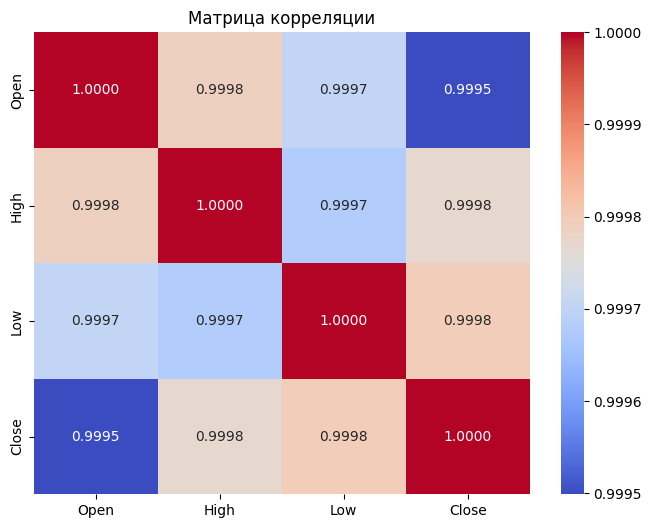

In [9]:
plt.figure(figsize=(8, 6))
sns.heatmap(df.iloc[:, :-2].corr(), annot=True, cmap='coolwarm', fmt='.4f')
plt.title('Матрица корреляции')
plt.show()

# Foster-Stewart criterion

Text(0, 0.5, 'Price')

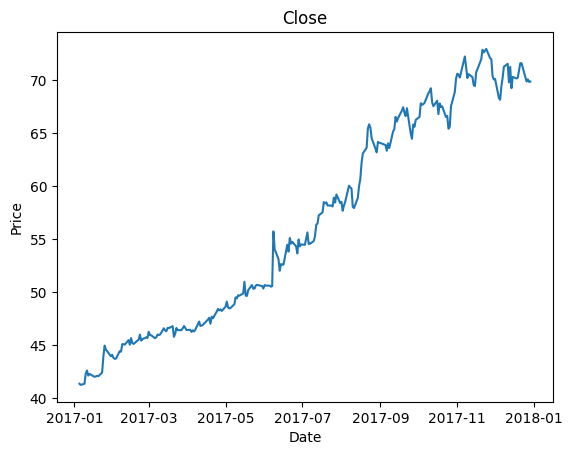

In [10]:
plt.plot(df[2017-1-1:].index, df[2017-1-1:]['Close'])
plt.title('Close')
plt.xlabel('Date')
plt.ylabel('Price')

In [11]:
def Foster_Stewart_method(series):
    n = len(series)
    m = np.array([1 if np.all(number > series[:i+1]) else (0) for i, number in enumerate(series[1:])])
    l = np.array([1 if np.all(number < series[:i+1]) else (0) for i, number in enumerate(series[1:])])
    d = m - l # {1, 0, -1}

    D = d.sum()
    sigm = math.sqrt(2*math.log(n)-0.8456)
    t_observ = D/sigm
    
    # 2.596 for n ~ 250 where p=0,01
    t_critical = float(input(f'Enter t_critical for n - 1 ={n - 1}: '))
    if math.fabs(t_observ) > t_critical:
        print('There is a trend')
    else:
        print('There isn`t a trend')

In [12]:
Foster_Stewart_method(df[2017-1-1:]['Close'].values)

Enter t_critical for n - 1 =248:  2.596


There is a trend


# Smoothing with Weighted Moving Averages (МНК)

In [13]:
df2 = data.iloc[:, :-2]
df2

,Open,High,Low,Close
Date,,,,
2006-01-03,39.69,41.22,38.79,40.91
2006-01-04,41.22,41.90,40.77,40.97
2006-01-05,40.93,41.73,40.85,41.53
2006-01-06,42.88,43.57,42.80,43.21
2006-01-09,43.10,43.66,42.82,43.42
...,...,...,...,...
2017-12-22,71.42,71.87,71.22,71.58
2017-12-26,70.94,71.39,69.63,69.86
2017-12-27,69.77,70.49,69.69,70.06


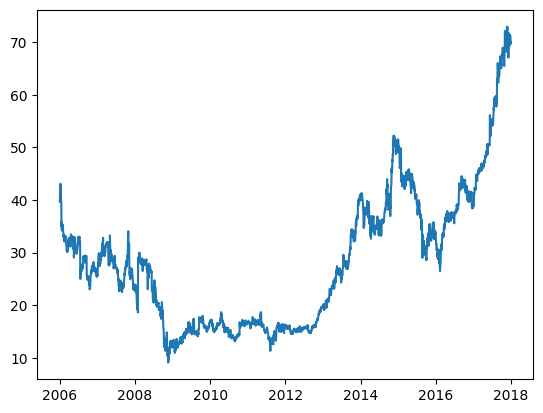

In [14]:
plt.plot(df2.index, df2.values[:, 0])

In [15]:
def get_matrix(window, polynom_degree=3):
  a = [Symbol('a' + str(i)) for i in range(polynom_degree + 1)]
  y_t = lambda t: a[0] + a[1]*t + a[2]*t**2 + a[3]*t**3

  y_i, t = [], []
  p = int((window-1)/2) 
    
  for i in range(window):
    # -p <= t <= p
    t.append(-1*p + i) 
    y_i.append(Symbol('y_' + str(t[-1]))) 

  Q = 0
  for i in range(window):
    Q += (y_i[i] - y_t(t[i])) ** 2 

  matrix = [diff(Q, a[i]) for i in range(len(a))]

  return matrix, Q, y_i, p, y_t, a

In [16]:
def param_identification(data, window, polynom_degree=3):
  matrix, Q, yi, p, y_t, a = get_matrix(window, polynom_degree)
  a_solve = linsolve(matrix, a) # finding koeffs
  a0 = a_solve.args[0][0] # a0

  w = [a0.coeff(yi[i]) for i in range(window)]
  coeffs = [w[i] / sum(w) for i in range(window)] # Normalize koeffs
  solves = []
  for i in range(p, len(data) - p):
    solve = 0
    for j in range(len(coeffs)):
      solve += data[i-p : i+p+1][j] * coeffs[j]
    solves.append(solve)

  return solves, p

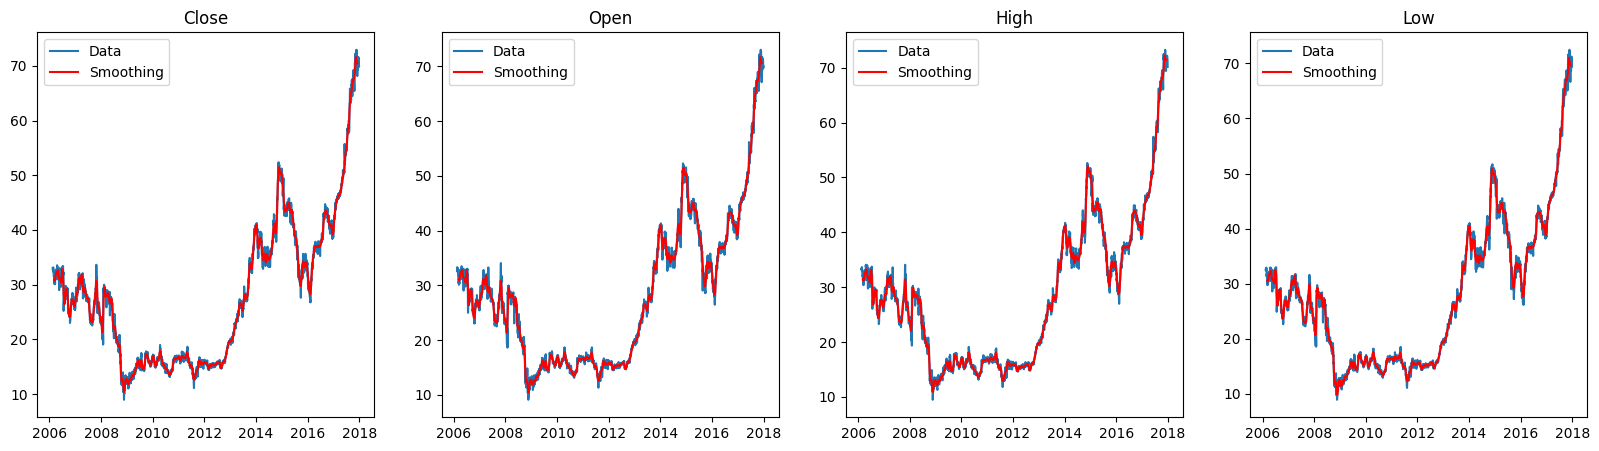

In [17]:
polynom_degree = 3
window = 31
cols_name = ['Close', 'Open', 'High', 'Low']

fig, axs = plt.subplots(1, 4, figsize=(20, 5))
for col in range(len(cols_name)):
  y = df2[cols_name[col]][window - 1:].tolist()
  y_wma, p = param_identification(y, window, polynom_degree)
  axs[col].plot(df2.index[window - 1:], df2[cols_name[col]][window - 1:], label='Data')
  axs[col].plot(df2.index[window - 1:][p : -p], y_wma, c='r', label='Smoothing')
  axs[col].legend()
  axs[col].set_title(cols_name[col])

# Clustering for weighted moving average

In [18]:
!pip install tsfresh

In [19]:
df2['Date_idx'] = df2.index
df2

,Open,High,Low,Close,Date_idx
Date,,,,,
2006-01-03,39.69,41.22,38.79,40.91,2006-01-03
2006-01-04,41.22,41.90,40.77,40.97,2006-01-04
2006-01-05,40.93,41.73,40.85,41.53,2006-01-05
2006-01-06,42.88,43.57,42.80,43.21,2006-01-06
2006-01-09,43.10,43.66,42.82,43.42,2006-01-09
...,...,...,...,...,...
2017-12-22,71.42,71.87,71.22,71.58,2017-12-22
2017-12-26,70.94,71.39,69.63,69.86,2017-12-26
2017-12-27,69.77,70.49,69.69,70.06,2017-12-27


In [20]:
from tsfresh import extract_features
extracted_features = extract_features(df2, column_id="Date_idx", column_sort="Close")

Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 20/20 [06:52<00:00, 20.61s/it]


In [21]:
print(extracted_features.shape, extracted_features.columns)
extracted_features

(3019, 2364) Index(['Open__variance_larger_than_standard_deviation',
       'Open__has_duplicate_max', 'Open__has_duplicate_min',
       'Open__has_duplicate', 'Open__sum_values', 'Open__abs_energy',
       'Open__mean_abs_change', 'Open__mean_change',
       'Open__mean_second_derivative_central', 'Open__median',
       ...
       'Low__fourier_entropy__bins_5', 'Low__fourier_entropy__bins_10',
       'Low__fourier_entropy__bins_100',
       'Low__permutation_entropy__dimension_3__tau_1',
       'Low__permutation_entropy__dimension_4__tau_1',
       'Low__permutation_entropy__dimension_5__tau_1',
       'Low__permutation_entropy__dimension_6__tau_1',
       'Low__permutation_entropy__dimension_7__tau_1',
       'Low__query_similarity_count__query_None__threshold_0.0',
       'Low__mean_n_absolute_max__number_of_maxima_7'],
      dtype='object', length=2364)


,Open__variance_larger_than_standard_deviation,Open__has_duplicate_max,Open__has_duplicate_min,Open__has_duplicate,Open__sum_values,Open__abs_energy,Open__mean_abs_change,Open__mean_change,Open__mean_second_derivative_central,Open__median,...,Low__fourier_entropy__bins_5,Low__fourier_entropy__bins_10,Low__fourier_entropy__bins_100,Low__permutation_entropy__dimension_3__tau_1,Low__permutation_entropy__dimension_4__tau_1,Low__permutation_entropy__dimension_5__tau_1,Low__permutation_entropy__dimension_6__tau_1,Low__permutation_entropy__dimension_7__tau_1,Low__query_similarity_count__query_None__threshold_0.0,Low__mean_n_absolute_max__number_of_maxima_7
2006-01-03,0.0,0.0,0.0,0.0,39.69,1575.2961,NaN,NaN,NaN,39.69,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-01-04,0.0,0.0,0.0,0.0,41.22,1699.0884,NaN,NaN,NaN,41.22,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-01-05,0.0,0.0,0.0,0.0,40.93,1675.2649,NaN,NaN,NaN,40.93,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-01-06,0.0,0.0,0.0,0.0,42.88,1838.6944,NaN,NaN,NaN,42.88,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-01-09,0.0,0.0,0.0,0.0,43.10,1857.6100,NaN,NaN,NaN,43.10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-22,0.0,0.0,0.0,0.0,71.42,5100.8164,NaN,NaN,NaN,71.42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-12-26,0.0,0.0,0.0,0.0,70.94,5032.4836,NaN,NaN,NaN,70.94,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-12-27,0.0,0.0,0.0,0.0,69.77,4867.8529,NaN,NaN,NaN,69.77,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-12-28,0.0,0.0,0.0,0.0,70.12,4916.8144,NaN,NaN,NaN,70.12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
extracted_features_cleaned=extracted_features.dropna(axis=1)
extracted_features_cleaned.head()

,Open__variance_larger_than_standard_deviation,Open__has_duplicate_max,Open__has_duplicate_min,Open__has_duplicate,Open__sum_values,Open__abs_energy,Open__median,Open__mean,Open__length,Open__standard_deviation,...,Low__ratio_beyond_r_sigma__r_7,Low__ratio_beyond_r_sigma__r_10,"Low__linear_trend_timewise__attr_""rvalue""",Low__count_above__t_0,Low__count_below__t_0,Low__lempel_ziv_complexity__bins_2,Low__lempel_ziv_complexity__bins_3,Low__lempel_ziv_complexity__bins_5,Low__lempel_ziv_complexity__bins_10,Low__lempel_ziv_complexity__bins_100
2006-01-03,0.0,0.0,0.0,0.0,39.69,1575.2961,39.69,39.69,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
2006-01-04,0.0,0.0,0.0,0.0,41.22,1699.0884,41.22,41.22,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
2006-01-05,0.0,0.0,0.0,0.0,40.93,1675.2649,40.93,40.93,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
2006-01-06,0.0,0.0,0.0,0.0,42.88,1838.6944,42.88,42.88,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
2006-01-09,0.0,0.0,0.0,0.0,43.10,1857.6100,43.10,43.10,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0


In [23]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
extracted_features_cleaned_std = scaler.fit_transform(extracted_features_cleaned)

In [24]:
from sklearn.decomposition import PCA

# Для уменьшения размерности данных, сохраняя при этом как можно больше информации.
pca = PCA()
pca.fit(extracted_features_cleaned_std)

PCA()

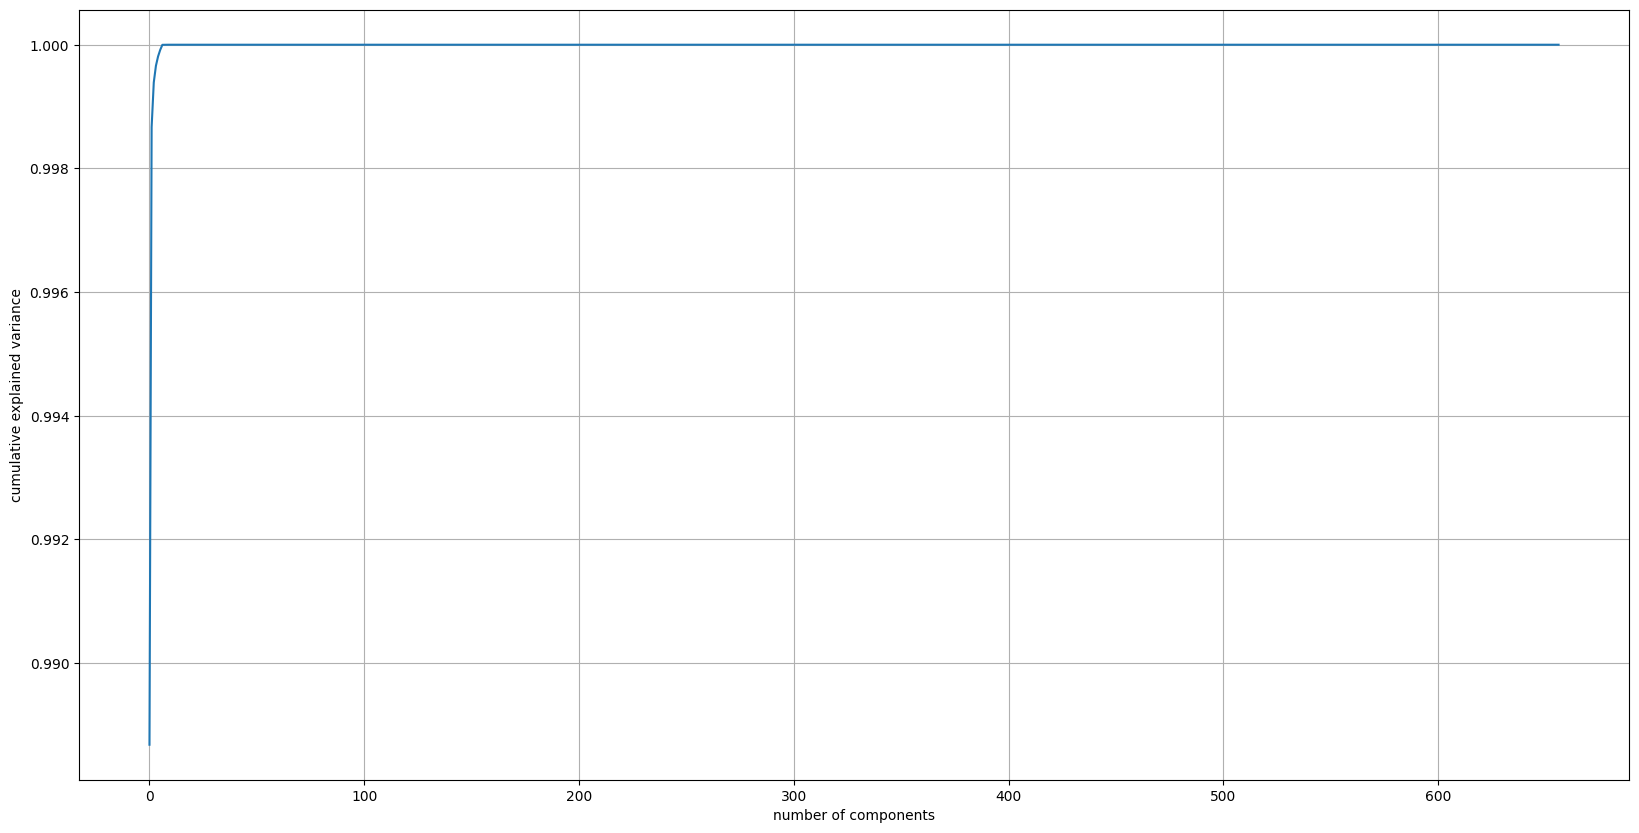

In [25]:
# Это позволяет увидеть, насколько много информации объясняется при добавлении каждой следующей главной компоненты.
plt.figure(figsize=(20,10))
plt.grid()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [26]:
pca = PCA(n_components=10)
pca.fit(extracted_features_cleaned_std)

PCA(n_components=10)

In [27]:
scores_pca = pca.transform(extracted_features_cleaned_std)

In [28]:
from sklearn.cluster import KMeans

# WCSS - сумма квадратов расстояний от каждой точки до ближайшего центра кластера.
# Чем меньше значение WCSS, тем лучше кластеризация
wcss = []
for i in range(1,10):
    km = KMeans(n_clusters=i) 
    km.fit(scores_pca)
    wcss.append(km.inertia_)

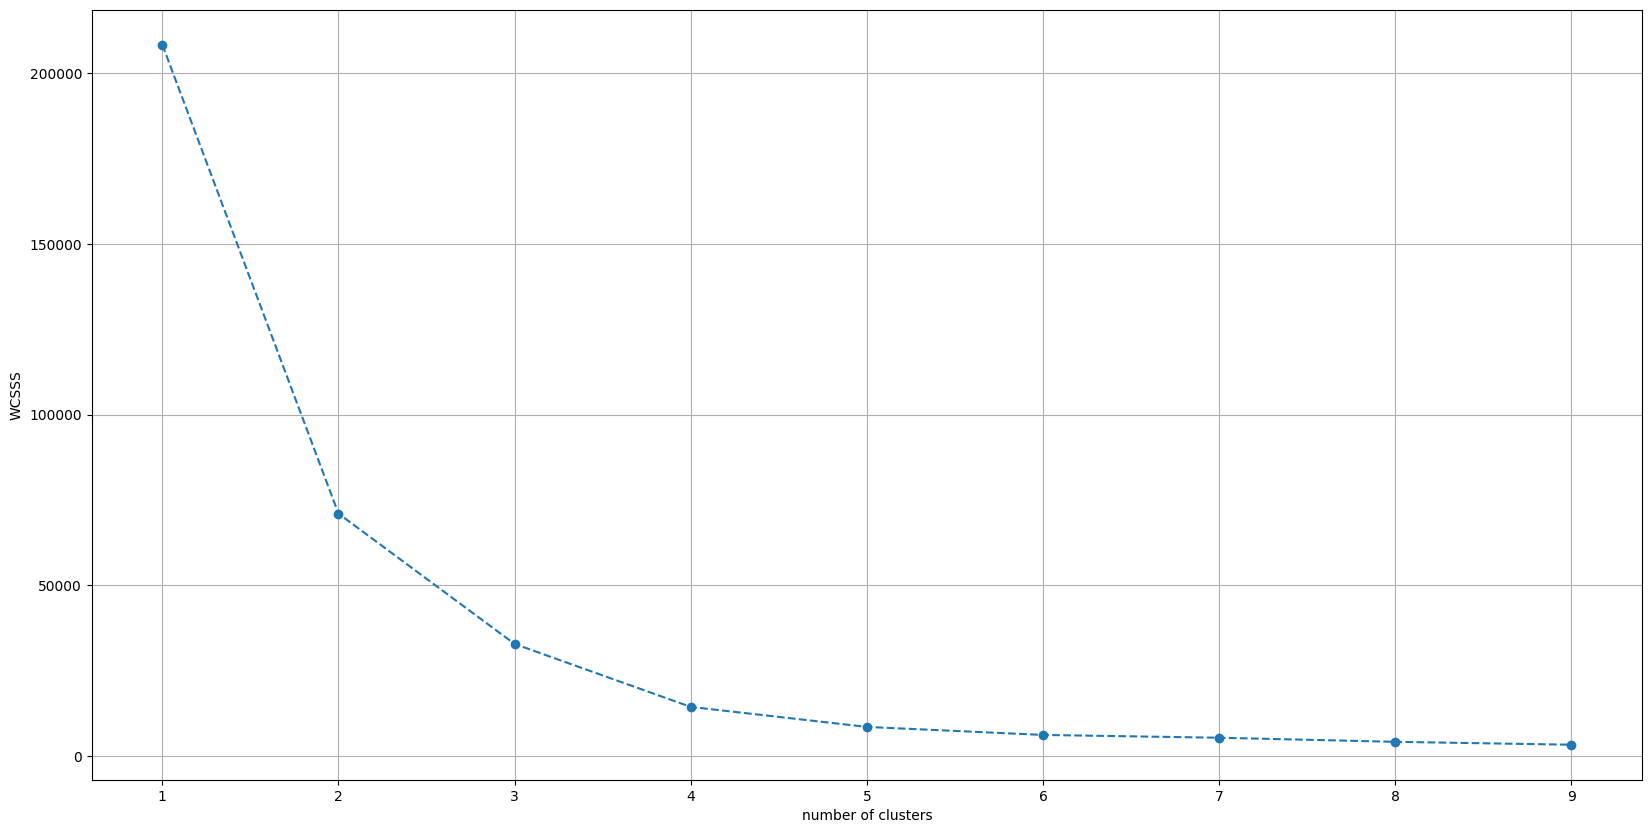

In [29]:
plt.figure(figsize=(20,10))
plt.grid()
plt.plot(range(1,10),wcss,marker='o',linestyle='--')
plt.xlabel('number of clusters')
plt.ylabel('WCSSS');

In [34]:
# cluster configuration
N_CLUSTERS = 4

km = KMeans(
    n_clusters=N_CLUSTERS
)
pca_km = km.fit_predict(scores_pca)
np.unique(pca_km,return_counts=True)

(array([0, 1, 2, 3]), array([ 699, 1179, 1001,  140], dtype=int64))

In [35]:
# split data on clusters

df_lbl = pd.DataFrame()
extracted_features_cleaned['Date_idx']=extracted_features_cleaned.index
df_lbl['Date_idx'] = extracted_features_cleaned['Date_idx']

df_lbl['label'] = pca_km
df_mrg = df2.merge(df_lbl, how='left')
print(df_mrg.shape, df2.shape)

df_mrg

(3019, 6) (3019, 5)


C:\Users\Chiki\AppData\Local\Temp\ipykernel_8672\1938668370.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extracted_features_cleaned['Date_idx']=extracted_features_cleaned.index


,Open,High,Low,Close,Date_idx,label
0,39.69,41.22,38.79,40.91,2006-01-03,0
1,41.22,41.90,40.77,40.97,2006-01-04,0
2,40.93,41.73,40.85,41.53,2006-01-05,0
3,42.88,43.57,42.80,43.21,2006-01-06,0
4,43.10,43.66,42.82,43.42,2006-01-09,0
...,...,...,...,...,...,...
3014,71.42,71.87,71.22,71.58,2017-12-22,3
3015,70.94,71.39,69.63,69.86,2017-12-26,3
3016,69.77,70.49,69.69,70.06,2017-12-27,3
3017,70.12,70.32,69.51,69.82,2017-12-28,3


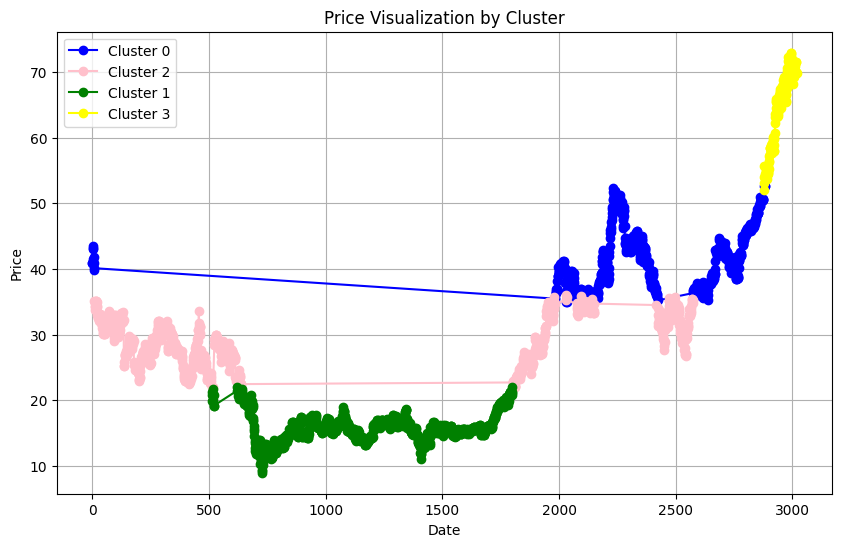

In [42]:
dates = pd.date_range(start=0, periods=len(df_mrg))
df = pd.DataFrame(df_mrg, index=dates)

# Определение цветов для каждого кластера
colors = {0: 'blue', 1: 'green', 2: 'pink', 3: 'yellow'}

# Визуализация данных
plt.figure(figsize=(10, 6))

for cluster in df_mrg['label'].unique():
    cluster_data = df_mrg[df_mrg['label'] == cluster]
    plt.plot(cluster_data.index, cluster_data['Close'], 
             color=colors[cluster], 
             label=f'Cluster {cluster}', 
             marker='o')

plt.title('Price Visualization by Cluster')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

In [43]:
df_mrg

,Open,High,Low,Close,Date_idx,label
0,39.69,41.22,38.79,40.91,2006-01-03,0
1,41.22,41.90,40.77,40.97,2006-01-04,0
2,40.93,41.73,40.85,41.53,2006-01-05,0
3,42.88,43.57,42.80,43.21,2006-01-06,0
4,43.10,43.66,42.82,43.42,2006-01-09,0
...,...,...,...,...,...,...
3014,71.42,71.87,71.22,71.58,2017-12-22,3
3015,70.94,71.39,69.63,69.86,2017-12-26,3
3016,69.77,70.49,69.69,70.06,2017-12-27,3
3017,70.12,70.32,69.51,69.82,2017-12-28,3


In [44]:
import warnings
warnings.filterwarnings("ignore")

In [58]:
def visualization(window = 31):
    polynom_degree=3
    cols_name = ['Close', 'Open', 'High', 'Low']
    fig, axs = plt.subplots(1, 4, figsize=(20, 5))
    for col in range(len(cols_name)):
      for cluster in df_mrg['label'].unique():
          data = df_mrg.where(df_mrg['label'] == cluster)
          y = data[cols_name[col]][window - 1:].tolist()
          y_wma, p = param_identification(y, window, polynom_degree)
          axs[col].plot(data.index[window - 1:], data[cols_name[col]][window - 1:], color=colors[cluster], label='Data')
          axs[col].plot(data.index[window - 1:][p : -p], y_wma, c='r', label='Smoothing')
          # axs[col].legend()
          plt.title(cols_name[col])

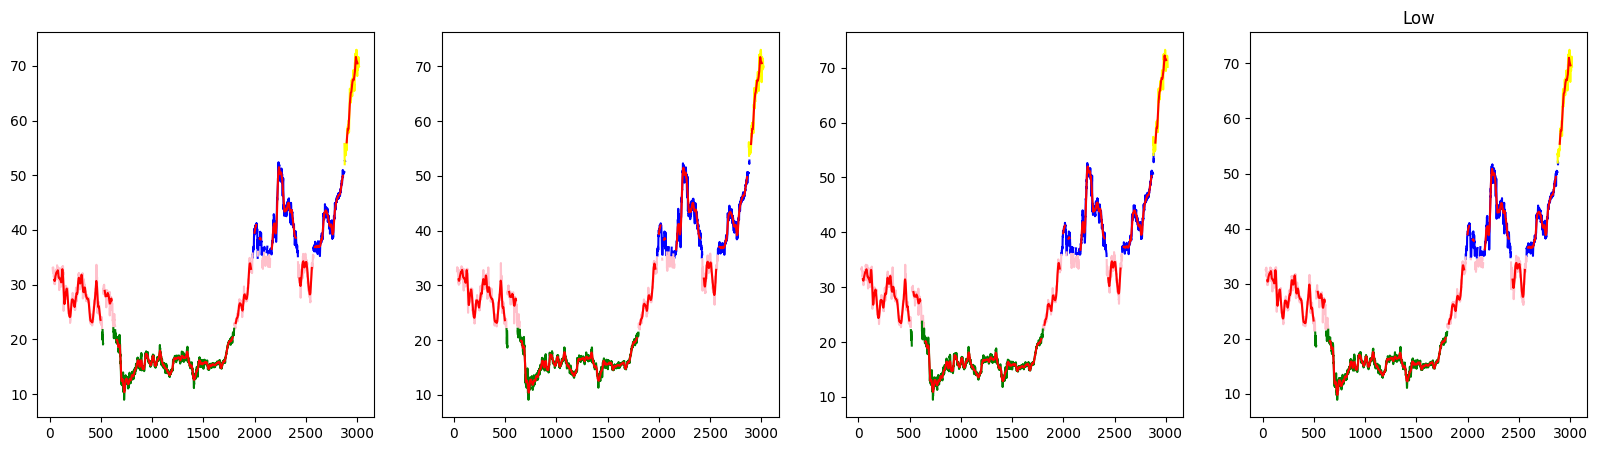

In [59]:
visualization(window = 31)

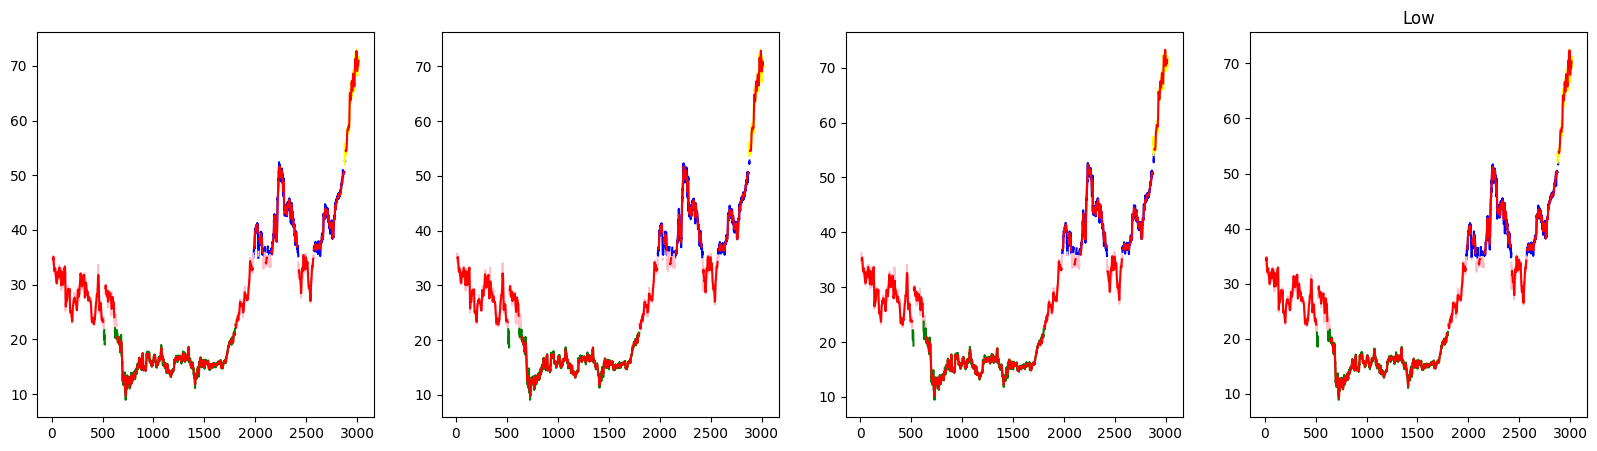

In [60]:
visualization(window = 11)

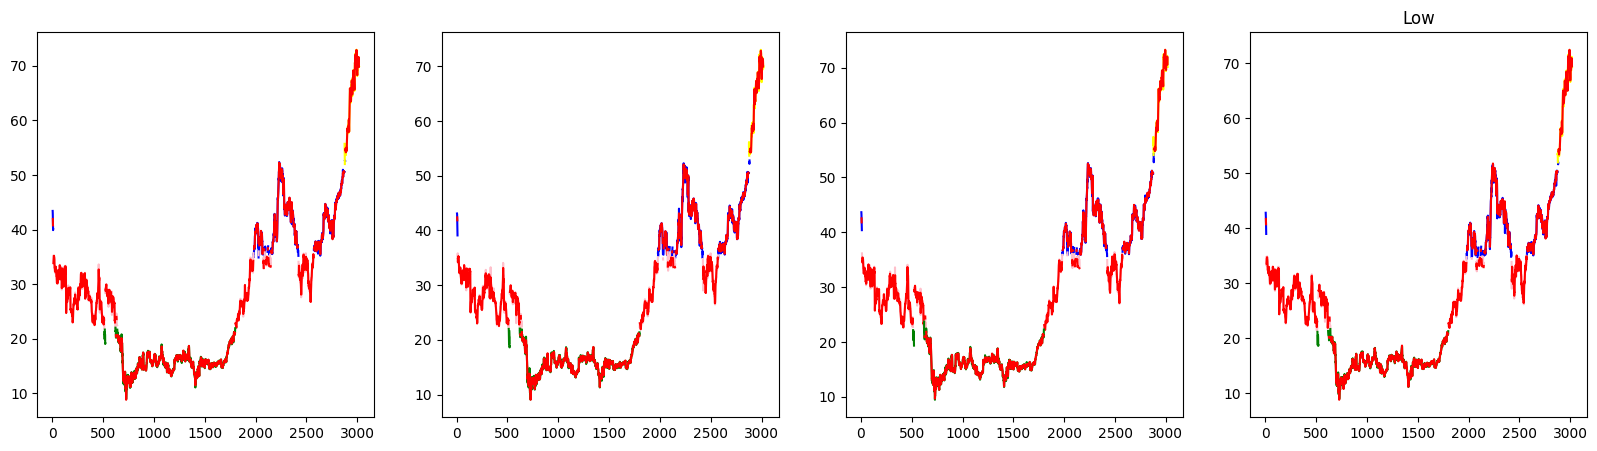

In [61]:
visualization(window = 5)